# Imports and Constants

In [1]:
import numpy as np
import pandas as pd
import sklearn
import random
import os

from loadData import get_maps, get_masks
from masks import apply_mask_to_maps, get_part_of_maps
from decoding import Decoder

C:\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Python38\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Python38\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
SEED = 0
random.seed(SEED)
n_subjects = 2
classes = ['Up', 'Down', 'Right', 'Left']
nb_runs = 12
length = nb_runs * len(classes)
subjects_ids = range(1, 3)  # TODO modify this to get all subjects (here we only have 1 for the example)

class_labels = [""] * (2 * length)
for i in range(length * 2):
    class_labels[i] = classes[(i // nb_runs) % len(classes)]
labels = dict()
labels["vis"] = np.array(class_labels[:length])
labels["aud"] = np.array(class_labels[length:])

classical_tasks_regions = [(["vis"], ["V5_R", "V5_L"]),
                           (["aud"], ["PT_R", "PT_L"]),
                           (["aud"], ["V5_R", "V5_L"])]

cross_modal_task_regions = [(["vis", "aud"], ["V5_R", "V5_L"])]

classifier = sklearn.svm.SVC(C=1, random_state=SEED)  # default parameters, there is clearly improvements to be
# made here
decoder = Decoder(n_perm=1000, model=classifier, n_classes=len(classes), n_splits=nb_runs, seed=SEED)

# Loading data and decoding

------------------ SUBJECT 1


ValueError: Mask affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
 is different from img affine:
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -112.]
 [   0.    0.    3.  -70.]
 [   0.    0.    0.    1.]]

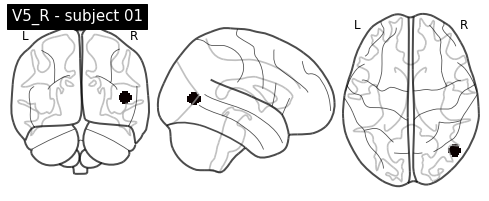

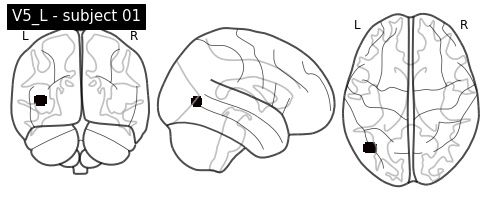

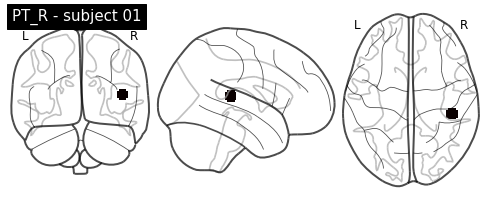

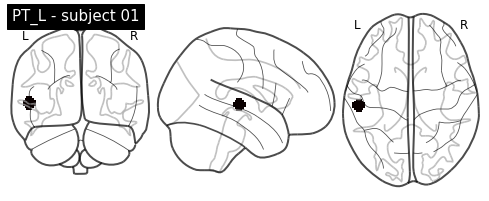

In [3]:
cv_scores = [dict() for _ in subjects_ids]
p_values = [dict() for _ in subjects_ids]
scores_perms = [dict() for _ in subjects_ids]

for i, subj_id in enumerate(subjects_ids):
    print("------------------ SUBJECT " + str(subj_id))
    t_maps, beta_maps = get_maps([subj_id])
    masks = get_masks([subj_id], plot=True)
    maps = apply_mask_to_maps(t_maps, masks)
    maps_masked = dict()
    maps_masked["vis"] = get_part_of_maps(maps, 0, length)  # maps acquired for the vision experiment
    maps_masked["aud"] = get_part_of_maps(maps, length, 2 * length)  # maps acquired for the audition experiment

    print("Loading done")
    # classical decoding : training on a task and decoding on other samples from same task
    for tasks, regions in classical_tasks_regions:
        cv_sc, p_val, scores_perm = decoder.classify_tasks_regions(maps_masked, labels, tasks, regions)
        cv_scores[i].update(cv_sc)
        p_values[i].update(p_val)
        scores_perms[i].update(scores_perm)

    # cross-modal decoding : training on a task and decoding on samples from another task
    for tasks, regions in cross_modal_task_regions:
        scores_cross_mod = decoder.cross_modal_decoding(maps_masked, labels, tasks, regions)
        cv_scores[i].update(scores_cross_mod)

    print("Decoding done")

# Saving results

In [4]:
output_directory = "out"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [16]:
df_cv_scores = pd.DataFrame(columns=list(cv_scores[0].keys()))
for score_dico in cv_scores :
    df_cv_scores = df_cv_scores.append(score_dico, ignore_index=True)

df_cv_scores.index = subjects_ids
df_cv_scores.to_csv("out/cv_scores.csv")

In [17]:
df_p_val = pd.DataFrame(columns=list(p_values[0].keys()))
for p_val_dico in p_values :
    df_p_val = df_p_val.append(p_val_dico, ignore_index=True)

df_p_val.index = subjects_ids
df_p_val.to_csv("out/p_values.csv")

In [13]:
df_perms_scores = pd.DataFrame(scores_perms)
df_perms_scores.index = subjects_ids
df_perms_scores.to_csv("out/perms_scores.csv")